In [1]:
# Topic Model for GSAi Prompt and Response Data using data from 3/14-3/31
# Purpose: Build a topic model that will help us uncover topics that may have been missed in the AI safety teams topic log
# Using only LDAvis, 10 topics only
# USER ONLY
# This also applies bigram/trigram function to topic model
# Author: Kai Cobb
# Last updated: 04/07/2025 

In [2]:

!pip install pandas
!pip install numpy
!pip install spacy
!pip install nltk
!pip install sentence-transformers
!pip install bertopic
!pip install gensim
!pip install pyLDAvis
!pip install scikit-learn

import re
import pandas as pd
import numpy as np
import spacy
import nltk
import json
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # For Gensim LDA models
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud
from nltk.util import ngrams





import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Load English NLP model for lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Load stopwords
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     D:\Users\kaiecobb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     D:\Users\kaiecobb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
##################################
# ---- Step 1:Load the Data ---- #
##################################

In [4]:

# Load prompts dataset (replace with actual file path if needed)
df= pd.read_excel(r"D:\Users\kaiecobb\Documents\GitHub\NLP4Survey\Customer-Data-Survey-Analysis\Notebooks\GSAi Topic Model\MSG-P-AI-datadog-20250403.xlsx")

type(df)

# Overview of dataset 
print(df.info()) # Check column types and missing values
print(df.describe()) # Summary Statistics

#Preview first few rows
df.head()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46574 entries, 0 to 46573
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   role         46574 non-null  object        
 1   content      46535 non-null  object        
 2   id           46574 non-null  object        
 3   modelId      46574 non-null  object        
 4   timestamp    46574 non-null  datetime64[ns]
 5   day_of_week  46574 non-null  object        
 6   hour         46574 non-null  int64         
 7   month        46574 non-null  int64         
 8   day          46574 non-null  int64         
 9   year         46574 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 3.6+ MB
None
                           timestamp          hour    month           day  \
count                          46574  46574.000000  46574.0  46574.000000   
mean   2025-03-24 12:12:04.103340800     16.067699      3.0     23.817860  

,role,content,id,modelId,timestamp,day_of_week,hour,month,day,year
0,user,I’m back. Thought of a new question/ use for you.,3886157475915644557375277560587615494206680964...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-22 03:14:41,Saturday,3,3,22,22
1,assistant,Great! I'm ready to help you. What question or...,3886157475915644557375277560587615494206680964...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-22 03:14:41,Saturday,3,3,22,22
2,user,Can you make a basic Gnatt chart?,3886157475915644557375277560587615494206680964...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-22 03:14:41,Saturday,3,3,22,22
3,assistant,I can help you understand Gantt charts and pro...,3886157475915644557375277560587615494206680964...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-22 03:14:41,Saturday,3,3,22,22
4,user,Then we must invent a new way to track a proje...,3886157475915644557375277560587615494206680964...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-22 03:14:41,Saturday,3,3,22,22
...,...,...,...,...,...,...,...,...,...,...
46569,assistant,"I apologize, but I cannot draft an email about...",3887331378222597129965262380407785637823496147...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-28 05:27:57,Friday,5,3,28,28
46570,assistant,Here's a draft email template for requesting l...,3887331378222597129965262380407785637823496147...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-28 05:27:57,Friday,5,3,28,28
46571,user,This is good,3887331378222597129965262380407785637823496147...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-28 05:27:57,Friday,5,3,28,28
46572,assistant,Excellent. Please go ahead and personalize the...,3887331378222597129965262380407785637823496147...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-28 05:27:57,Friday,5,3,28,28


In [5]:
############################################
# ---- Step 2: EDA and Pre-processing ---- #
############################################

In [6]:
# Drop Assistant rows
# Value to drop
value_to_drop = 'assistant'

# Get indices of rows where 'col1' equals value_to_drop
indices_to_drop = df[df['role'] == value_to_drop].index

# Drop rows by index
df.drop(indices_to_drop, inplace=True)

print(df)

       role                                            content  \
0      user  I’m back. Thought of a new question/ use for you.   
2      user                  Can you make a basic Gnatt chart?   
4      user  Then we must invent a new way to track a proje...   
6      user             I’ll be back later. We are doing this.   
8      user  Oh geez, thank you for your patience, my kids ...   
...     ...                                                ...   
46564  user                                   What is “aider”?   
46567  user  What does the command “touch -h -d 1980-01-02 ...   
46568  user  draft an email to ask if there is any docs in ...   
46571  user                                       This is good   
46573  user  Does the NIST Metaschema specification state i...   

                                                      id  \
0      3886157475915644557375277560587615494206680964...   
2      3886157475915644557375277560587615494206680964...   
4      38861574759156445573

In [7]:

df.rename(columns={'content': 'prompt'}, inplace=True)

# Clean and Preprocess Text (LDA & BERTopic Compatible)
def preprocess_text(text):
    """preprocess text for both BERT and LDA."""
    if pd.isnull(text): # Handle missing values
        return ""
    
    text = text.lower()  # Lowercase
    text = re.sub(r'\s+', ' ', text) # Remove extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation & numbers

    doc = nlp(text)
    tokens = [token.lemma_ for token in nlp(text) if token.text not in stop_words and len(token.text) > 2] # Lemmatization and stopword removal
    return " ".join(tokens)

# apply preprocess function
df["cleaned_prompts"] = df["prompt"].astype(str).apply(preprocess_text)

# Remove empty rows
df = df[df["cleaned_prompts"].str.strip() !=""]

# Remove duplicates
df = df.drop_duplicates(subset=["cleaned_prompts"])

# Check cleaned prompts
df["cleaned_prompts"].head()

0                          back think new question use
2                               make basic gnatt chart
4    must invent new way track project schedule pre...
6                                       ill back later
8                  geez thank patience kid still awake
Name: cleaned_prompts, dtype: object

[('use', 7234), ('gsa', 6144), ('service', 5837), ('provide', 5328), ('work', 4932), ('contract', 4804), ('project', 4601), ('system', 4408), ('agency', 4303), ('need', 4235), ('include', 4203), ('new', 3666), ('datum', 3615), ('requirement', 3512), ('information', 3406), ('process', 3266), ('make', 3230), ('management', 3159), ('government', 3122), ('federal', 3068)]


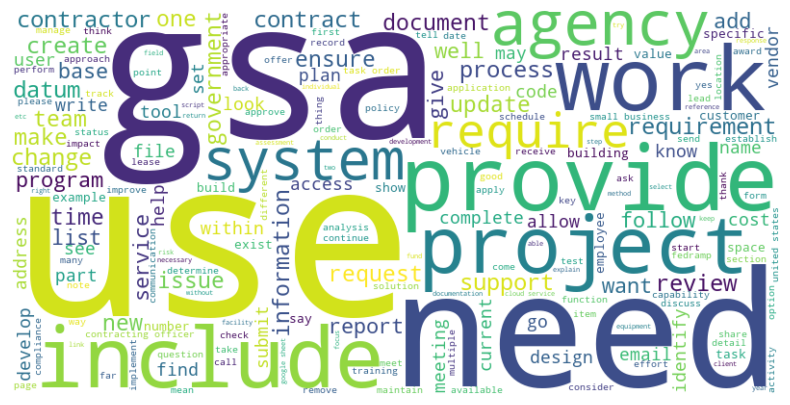

In [8]:
# Word Frequency Analysis

# Tokenize cleaned text
all_words = " ".join(df["cleaned_prompts"]).split()
word_freq = Counter(all_words)

# Most common words
print(word_freq.most_common(20))

# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [9]:
# Bi-gram & Tri-gram Analysis

# Function to generate n-grams
def get_ngrams(texts, n=2, top_n=20):
    ngram_list = []
    for text in texts:
        tokens = text.split()
        ngram_list.extend(list(ngrams(tokens, n)))
    return Counter(ngram_list).most_common(top_n)

# Show top bi-grams & tri-grams
print("Top Bigrams:", get_ngrams(df["cleaned_prompts"], 2))
print("Top Trigrams:", get_ngrams(df["cleaned_prompts"], 3))



Top Bigrams: [(('contracting', 'officer'), 590), (('small', 'business'), 559), (('task', 'order'), 452), (('united', 'states'), 450), (('would', 'like'), 423), (('cloud', 'service'), 410), (('contractor', 'shall'), 410), (('google', 'sheet'), 405), (('federal', 'government'), 349), (('federal', 'agency'), 334), (('executive', 'order'), 334), (('good', 'practice'), 321), (('col', 'cdrl'), 319), (('let', 'know'), 313), (('col', 'tar'), 303), (('work', 'group'), 302), (('tar', 'tar'), 297), (('system', 'prompt'), 292), (('project', 'management'), 280), (('general', 'services'), 275)]
Top Trigrams: [(('col', 'tar', 'tar'), 296), (('general', 'services', 'administration'), 269), (('tar', 'tar', 'col'), 261), (('level', 'addition', 'level'), 216), (('cloud', 'service', 'provider'), 214), (('col', 'cdrl', 'col'), 214), (('cdrl', 'col', 'cdrl'), 214), (('tar', 'col', 'tar'), 210), (('col', 'rip', 'rip'), 207), (('classposttimep', 'classposttimep', 'classposttimep'), 194), (('rip', 'rip', 'col'

In [10]:
# Check for Anomalies after Cleaning
# Make sure dataset is clean before modeling

# Check missing values
print(df.isnull().sum())

# Check duplicate prompts after cleaning
print("Duplicates:", df.duplicated(subset=["cleaned_prompts"]).sum())

# Check text length distribution
df["text_length"] = df["cleaned_prompts"].apply(lambda x: len(x.split()))
df["text_length"].describe()


role               0
prompt             1
id                 0
modelId            0
timestamp          0
day_of_week        0
hour               0
month              0
day                0
year               0
cleaned_prompts    0
dtype: int64
Duplicates: 0


count    25546.000000
mean        43.048696
std        216.908813
min          1.000000
25%          4.000000
50%          6.000000
75%         14.000000
max       5272.000000
Name: text_length, dtype: float64

In [11]:
# Formatting Processed Text for LDAvis
from gensim.models.phrases import Phrases, Phraser

def generate_bigrams_trigrams(texts, min_count=5, threshold=10):
    """
    Apply bigrams and trigrams to tokenized texts.
    """
    tokenized_texts = [text.split() for text in texts]

    # Build the bigram and trigram models
    bigram = Phrases(tokenized_texts, min_count=min_count, threshold=threshold)
    trigram = Phrases(bigram[tokenized_texts], threshold=threshold)

    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)

    # Apply the models
    return [trigram_mod[bigram_mod[doc]] for doc in tokenized_texts]

#Tokenize   
tokenized_texts = generate_bigrams_trigrams(df["cleaned_prompts"])
   
# Create dicitonary 
dictionary = Dictionary(tokenized_texts)

# Filter extremes 
dictionary.filter_extremes(no_below=5, no_above=0.7)

# Convert to corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

In [12]:
# Function to generate and save an EDA report


def generate_eda_report(df, text_column="cleaned_prompts", output_path="eda_report_10_Topics_LDA_ONLY_v2.json"):
    report = {}

    # Dataset Overview
    report["Dataset Summary"] = {
        "Total Rows": int(len(df)),
        "Missing Values": int(df[text_column].isnull().sum()),
        "Duplicate Entries": int(df.duplicated(subset=[text_column]).sum()),
        "Average Text Length": float(df[text_column].apply(lambda x: len(x.split())).mean()),
        "Min Text Length": int(df[text_column].apply(lambda x: len(x.split())).min()),
        "Max Text Length": int(df[text_column].apply(lambda x: len(x.split())).max()),
    }

    # Word Frequency Analysis
    all_words = " ".join(df[text_column]).split()
    word_freq = Counter(all_words)
    report["Top Words"] = [(word, int(freq)) for word, freq in word_freq.most_common(20)]

    # N-gram Analysis
    report["Top Bigrams"] = [(str(ngram), int(freq)) for ngram, freq in get_ngrams(df[text_column], 2)]
    report["Top Trigrams"] = [(str(ngram), int(freq)) for ngram, freq in get_ngrams(df[text_column], 3)]


    # Save report as JSON
    with open(output_path, "w") as f:
        json.dump(report, f, indent=4)

    print(f"EDA report saved to {output_path}")

# Run EDA and save results
generate_eda_report(df)

EDA report saved to eda_report_10_Topics_LDA_ONLY_v2.json


In [13]:
#################################
# ---- Step 3: Topic Model ---- #
#################################

In [14]:

# Define a Logging Function for tracking LDAvis and BERTopic results
import datetime

def log_results(model_name, parameters, topics, coherence_score, output_path="model_results_10_Topics_LDA_ONLY_v2.json"):
    """Logs model parameters and results."""
    log_entry = {
        "timestamp": str(datetime.datetime.now()),
        "model": model_name,
        "parameters": parameters,
        "topics": topics,
        "coherence_score": coherence_score,
    }

    # Load existing results if file exists
    try:
        with open(output_path, "r") as f:
            logs = json.load(f)
    except FileNotFoundError:
        logs = []

    logs.append(log_entry)

    # Save updated results
    with open(output_path, "w") as f:
        json.dump(logs, f, indent=4)

    print(f"Results logged to {output_path}")

In [15]:
###################
# LDA Topic Model #
###################

In [16]:

from itertools import product

# Function to train and evaluate LDA with different parameters
def tune_lda(dictionary, corpus, texts, num_topics_list, alpha_list, beta_list):
    best_model = None
    best_coherence = 0
    results = []

    # Create a list of all parameter combinations
    param_combinations = list(product(num_topics_list, alpha_list, beta_list))


    # Wrap the param combinations in tqdm
    for num_topics, alpha, beta in tqdm(param_combinations, desc="Tuning LDA Models", ncols=100):
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha=alpha,
            eta=beta
        )

        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model_lda.get_coherence()

        tqdm.write(f"Topics={num_topics}, Alpha={alpha}, Beta={beta}, Coherence={coherence_score:.4f}")

        results.append((num_topics, alpha, beta, coherence_score))

        # Track best model
        if coherence_score > best_coherence:
                best_model = lda_model
                best_coherence = coherence_score

    return best_model, results

# Define parameter search space
num_topics_list = [10]   # 10 as the intended number of topics
alpha_list = ['symmetric', 'asymmetric', 0.01, 0.1, 0.5]  # Test different alpha values
beta_list = ['symmetric', 0.01, 0.1, 0.5]  # Test different beta values

# Run LDA tuning
best_lda, lda_results = tune_lda(dictionary, corpus, tokenized_texts, num_topics_list, alpha_list, beta_list)

Tuning LDA Models:   5%|██▎                                          | 1/20 [01:36<30:27, 96.17s/it]

Topics=10, Alpha=symmetric, Beta=symmetric, Coherence=0.3909


Tuning LDA Models:  10%|████▌                                        | 2/20 [03:06<27:44, 92.45s/it]

Topics=10, Alpha=symmetric, Beta=0.01, Coherence=0.3577


Tuning LDA Models:  15%|██████▊                                      | 3/20 [04:40<26:31, 93.60s/it]

Topics=10, Alpha=symmetric, Beta=0.1, Coherence=0.3909


Tuning LDA Models:  20%|█████████                                    | 4/20 [06:27<26:18, 98.68s/it]

Topics=10, Alpha=symmetric, Beta=0.5, Coherence=0.5283


Tuning LDA Models:  25%|███████████▎                                 | 5/20 [08:01<24:13, 96.89s/it]

Topics=10, Alpha=asymmetric, Beta=symmetric, Coherence=0.4305


Tuning LDA Models:  30%|█████████████▌                               | 6/20 [09:31<22:03, 94.56s/it]

Topics=10, Alpha=asymmetric, Beta=0.01, Coherence=0.3723


Tuning LDA Models:  35%|███████████████▋                             | 7/20 [11:05<20:26, 94.32s/it]

Topics=10, Alpha=asymmetric, Beta=0.1, Coherence=0.4305


Tuning LDA Models:  40%|██████████████████                           | 8/20 [12:48<19:27, 97.31s/it]

Topics=10, Alpha=asymmetric, Beta=0.5, Coherence=0.5512


Tuning LDA Models:  45%|████████████████████▎                        | 9/20 [14:30<18:05, 98.70s/it]

Topics=10, Alpha=0.01, Beta=symmetric, Coherence=0.3956


Tuning LDA Models:  50%|██████████████████████                      | 10/20 [16:03<16:10, 97.09s/it]

Topics=10, Alpha=0.01, Beta=0.01, Coherence=0.3802


Tuning LDA Models:  55%|████████████████████████▏                   | 11/20 [17:40<14:31, 96.80s/it]

Topics=10, Alpha=0.01, Beta=0.1, Coherence=0.3956


Tuning LDA Models:  60%|█████████████████████████▊                 | 12/20 [19:27<13:20, 100.04s/it]

Topics=10, Alpha=0.01, Beta=0.5, Coherence=0.5289


Tuning LDA Models:  65%|████████████████████████████▌               | 13/20 [21:06<11:38, 99.82s/it]

Topics=10, Alpha=0.1, Beta=symmetric, Coherence=0.3909


Tuning LDA Models:  70%|██████████████████████████████▊             | 14/20 [22:37<09:42, 97.04s/it]

Topics=10, Alpha=0.1, Beta=0.01, Coherence=0.3577


Tuning LDA Models:  75%|█████████████████████████████████           | 15/20 [24:14<08:04, 96.89s/it]

Topics=10, Alpha=0.1, Beta=0.1, Coherence=0.3909


Tuning LDA Models:  80%|███████████████████████████████████▏        | 16/20 [25:57<06:35, 98.98s/it]

Topics=10, Alpha=0.1, Beta=0.5, Coherence=0.5283


Tuning LDA Models:  85%|█████████████████████████████████████▍      | 17/20 [27:34<04:54, 98.24s/it]

Topics=10, Alpha=0.5, Beta=symmetric, Coherence=0.4590


Tuning LDA Models:  90%|███████████████████████████████████████▌    | 18/20 [29:03<03:11, 95.60s/it]

Topics=10, Alpha=0.5, Beta=0.01, Coherence=0.4355


Tuning LDA Models:  95%|█████████████████████████████████████████▊  | 19/20 [30:40<01:35, 95.92s/it]

Topics=10, Alpha=0.5, Beta=0.1, Coherence=0.4590


Tuning LDA Models: 100%|████████████████████████████████████████████| 20/20 [32:22<00:00, 97.13s/it]

Topics=10, Alpha=0.5, Beta=0.5, Coherence=0.5332


In [17]:
# Record and Analyze Results

# Convert results to a DataFrame
lda_results_df = pd.DataFrame(lda_results, columns=["Num Topics", "Alpha", "Beta", "Coherence Score"])

# Sort by best coherence score
lda_results_df = lda_results_df.sort_values(by="Coherence Score", ascending=False)

# Display top 5 results
print(lda_results_df.head())

    Num Topics       Alpha Beta  Coherence Score
7           10  asymmetric  0.5         0.551183
19          10         0.5  0.5         0.533158
11          10        0.01  0.5         0.528883
3           10   symmetric  0.5         0.528331
15          10         0.1  0.5         0.528331


In [18]:
#save lda model
best_lda.save("best_lda_model_10_topics_LDA_ONLY_v2.model")

#save dicitonary
dictionary.save("lda_dictionary.dict")

#save corpus
gensim.corpora.MmCorpus.serialize("lda_corpus.mm", corpus)


In [19]:
########################################
### LDAvis Topic Model Visualization ###
########################################

In [20]:


# Prepare the LDA visualization based off of best LDA model with num_topics=10, alpha='0.5', and beta=0.5
lda_display = gensimvis.prepare(best_lda, corpus, dictionary, sort_topics=False)

# Show LDA visualization
pyLDAvis.display(lda_display)

pyLDAvis.save_html(lda_display, "lda_topics_visualization_10_Topics_LDA_ONLY_v2.html")
print("LDAvis HTML saved. Open 'lda_topics_visualization_10_Topics_LDA_ONLY_v2.html' to explore topics.")

LDAvis HTML saved. Open 'lda_topics_visualization_10_Topics_LDA_ONLY_v2.html' to explore topics.


In [22]:
# Get topic distributions for each document
doc_topics = best_lda.get_document_topics(corpus, minimum_probability=0)

# Convert to a DataFrame
topic_matrix = pd.DataFrame([[tup[1] for tup in doc] for doc in doc_topics])

# Rename columns to "Topic_0", "Topic_1", ..., "Topic_N"
topic_matrix.columns = [f'Topic_{i}' for i in range(best_lda.num_topics)]

# Add Document ID (if available)
topic_matrix['Document_ID'] = range(len(topic_matrix))

# Check the output
print(topic_matrix.head())


    Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
0  0.867072  0.025939  0.020779  0.017405  0.014975  0.013141  0.011706   
1  0.286336  0.553158  0.031176  0.026114  0.022465  0.019713  0.017561   
2  0.577677  0.013078  0.010513  0.008806  0.007574  0.182943  0.005921   
3  0.800855  0.038657  0.031168  0.026109  0.022464  0.019712  0.017560   
4  0.800453  0.038740  0.031232  0.026162  0.022508  0.019750  0.017595   

    Topic_7   Topic_8   Topic_9  Document_ID  
0  0.010554  0.009609  0.008819            0  
1  0.015833  0.014415  0.013229            1  
2  0.005338  0.183690  0.004460            2  
3  0.015832  0.014414  0.013229            3  
4  0.015863  0.014442  0.013255            4  


In [23]:
# Assign most dominant topic
topic_matrix['Dominant_Topic'] = topic_matrix.iloc[:, :-1].idxmax(axis=1)

# Convert "Topic_0" → 0, "Topic_1" → 1, etc.
topic_matrix['Dominant_Topic'] = topic_matrix['Dominant_Topic'].apply(lambda x: int(x.split('_')[1]))

print(topic_matrix[['Document_ID', 'Dominant_Topic']].head())


   Document_ID  Dominant_Topic
0            0               0
1            1               1
2            2               0
3            3               0
4            4               0


In [25]:
# Get top words for each topic
topic_words = {i: [word for word, _ in best_lda.show_topic(i, topn=10)] for i in range(best_lda.num_topics)}

# Convert to DataFrame
topic_word_df = pd.DataFrame.from_dict(topic_words, orient='index', columns=[f'Word_{i}' for i in range(10)])

print(topic_word_df.head())


       Word_0                 Word_1             Word_2  \
0        need                   work              would   
1         use                include             system   
2         gsa                 agency           employee   
3     fedramp                    csp     cloud_provider   
4  task_order  team_general_services  wwwgsagovgwac_gsa   

                                    Word_3                  Word_4  \
0                                   please                   email   
1                                    datum                 provide   
2                                  federal                 service   
3                                      ric  cloud_service_provider   
4  gwac_webpage_wwwgsagovgwacdashboard_gsa      administration_gsa   

                       Word_5       Word_6  \
0                         one         want   
1                        test  information   
2                         pbs       office   
3                     general   differen

In [26]:
topic_matrix.to_csv("document_topic_matrix_v2.csv", index=False)
topic_word_df.to_csv("topic_word_distribution_v2.csv", index=True)


In [27]:
# Get the dominant topic for each document
topics_per_doc = [max(best_lda[doc], key=lambda x: x[1])[0] for doc in corpus]

# Count the occurrences of each topic
from collections import Counter
topic_counts = Counter(topics_per_doc)

# Print topic distribution
for topic_id, count in sorted(topic_counts.items()):
    print(f"Topic {topic_id}: {count} documents")


Topic 0: 8747 documents
Topic 1: 3193 documents
Topic 2: 2049 documents
Topic 3: 359 documents
Topic 4: 106 documents
Topic 5: 3622 documents
Topic 6: 2833 documents
Topic 7: 1694 documents
Topic 8: 2789 documents
Topic 9: 154 documents


In [28]:
#Merge main df and topic_df
# Ensure main_df has a Document_ID column
main_df = df.reset_index().rename(columns={"index": "Document_ID"})

# Merge main_df with topic_df
merged_df = main_df.merge(topic_matrix, on="Document_ID", how="left")

# Check the first few rows
print(merged_df.head())


   Document_ID  role                                             prompt  \
0            0  user  I’m back. Thought of a new question/ use for you.   
1            2  user                  Can you make a basic Gnatt chart?   
2            4  user  Then we must invent a new way to track a proje...   
3            6  user             I’ll be back later. We are doing this.   
4            8  user  Oh geez, thank you for your patience, my kids ...   

                                                  id  \
0  3886157475915644557375277560587615494206680964...   
1  3886157475915644557375277560587615494206680964...   
2  3886157475915644557375277560587615494206680964...   
3  3886157475915644557375277560587615494206680964...   
4  3886157475915644557375277560587615494206680964...   

                                       modelId           timestamp  \
0  us.anthropic.claude-3-5-haiku-20241022-v1:0 2025-03-22 03:14:41   
1  us.anthropic.claude-3-5-haiku-20241022-v1:0 2025-03-22 03:14:41   
2 

In [29]:
merged_df

,Document_ID,role,prompt,id,modelId,timestamp,day_of_week,hour,month,day,...,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Dominant_Topic
0,0,user,I’m back. Thought of a new question/ use for you.,3886157475915644557375277560587615494206680964...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-22 03:14:41,Saturday,3,3,22,...,0.025939,0.020779,0.017405,0.014975,0.013141,0.011706,0.010554,0.009609,0.008819,0.0
1,2,user,Can you make a basic Gnatt chart?,3886157475915644557375277560587615494206680964...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-22 03:14:41,Saturday,3,3,22,...,0.013078,0.010513,0.008806,0.007574,0.182943,0.005921,0.005338,0.183690,0.004460,0.0
2,4,user,Then we must invent a new way to track a proje...,3886157475915644557375277560587615494206680964...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-22 03:14:41,Saturday,3,3,22,...,0.038740,0.031232,0.026162,0.022508,0.019750,0.017595,0.015863,0.014442,0.013255,0.0
3,6,user,I’ll be back later. We are doing this.,3886157475915644557375277560587615494206680964...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-22 03:14:41,Saturday,3,3,22,...,0.015679,0.012492,0.249141,0.008992,0.007890,0.117434,0.106266,0.005770,0.005295,0.0
4,8,user,"Oh geez, thank you for your patience, my kids ...",3886157475915644557375277560587615494206680964...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-22 03:14:41,Saturday,3,3,22,...,0.000289,0.000231,0.000193,0.000166,0.646580,0.000130,0.043317,0.308607,0.000098,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25541,46563,user,Does the VERA offer include MRA+10?,3887336199643709052285985841880920038744720377...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-28 06:03:59,Friday,6,3,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25542,46564,user,What is “aider”?,3887332885752972550635386831512127863528429222...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-28 05:39:13,Friday,5,3,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25543,46567,user,What does the command “touch -h -d 1980-01-02 ...,3887332885752972550635386831512127863528429222...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-28 05:39:13,Friday,5,3,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25544,46568,user,draft an email to ask if there is any docs in ...,3887331378222597129965262380407785637823496147...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-28 05:27:57,Friday,5,3,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
